In [1]:
# ----- 1) Imports & settings -----
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from wordcloud import WordCloud, STOPWORDS
import nltk
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import CountVectorizer

# plotting style
sns.set(style='whitegrid')
plt.rcParams['figure.figsize'] = (10,5)


In [2]:
try:
    nltk.data.find('tokenizers/punkt')
    nltk.data.find('corpora/stopwords')
    nltk.data.find('sentiment/vader_lexicon')
except Exception:
    nltk.download('punkt')
    nltk.download('stopwords')
    nltk.download('vader_lexicon')


[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Pratham\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Pratham\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package vader_lexicon to
[nltk_data]     C:\Users\Pratham\AppData\Roaming\nltk_data...


In [4]:
# ----- 2) Load data -----
DATA_DIR = '../Local Business Review Project NT/data/processed'

MASTER_PATHS = [
    os.path.join(DATA_DIR, 'master_sheet_combined.csv'),
]

def load_first_existing(paths):
    for p in paths:
        if os.path.exists(p):
            print("Loading", p)
            return pd.read_csv(p)
    
    fallback = [
        os.path.join(DATA_DIR, 'gyms_ahm_ban_combinned.csv'),
        os.path.join(DATA_DIR, 'salon_ahm_ban_combined.csv'),
        os.path.join(DATA_DIR, 'restaurant_ahm_ban_combined.csv'),
    ]
    for p in fallback:
        if os.path.exists(p):
            print("Loading fallback", p)
            return pd.read_csv(p)
    raise FileNotFoundError("No dataset found. Put master_sheet_combined.csv in ../data/processed or /mnt/data")

df = load_first_existing(MASTER_PATHS)
print("Loaded shape:", df.shape)
df.head()


Loading ../Local Business Review Project NT/data/processed\master_sheet_combined.csv
Loaded shape: (6627, 6)


,business_name,address,city,category,rating,review_text
0,Bihari Express,"bihari express, 40/3, 2nd Main Rd, Somasundara...","BTM,Bangalore",restaurant,5.0,"Perfect meal, delicious and served quickly. Lo..."
1,Cinnamon - Continental Delicacies By Ambrosia,"Cinnamon - Continental Delicacies by Ambrosia,...","Whitefield,Bangalore",restaurant,5.0,Top-notch food and service. Best place in town.
2,Slurpy Shakes,"Slurpy Shakes, Hotel Regenta Central Antarim, ...","Navrangpura,Ahmedabad",restaurant,4.2,Nice place with tasty food. Slight issues with...
3,Shree Swaminarayan Food Center,"Shree Swaminarayan Food Center, a-1\011 sun vi...","Ghatlodia,Ahmedabad",restaurant,5.0,Amazing food and great service! Highly recomme...
4,Brindhavana Nithya Bhojanalaya,"BRINDHAVANA NITHYA BHOJANALAYA, 181, 1st cross...","Kumaraswamy Layout & Uttarahalli,Bangalore",restaurant,4.0,Good experience overall. Worth a repeat visit.


In [5]:
# ----- 3) Normalize column names & check essentials -----
df = df.copy()

df.columns = [c.strip() for c in df.columns]
col_map = {}
for c in df.columns:
    lc = c.lower()
    if 'name' in lc and 'business' not in lc:
        col_map[c] = 'business_name'
    if 'business' in lc and 'name' in lc:
        col_map[c] = 'business_name'
    if 'address' in lc:
        col_map[c] = 'address'
    # try common review column names
    if lc in ('review_text','review','reviews','reviewtext','reviews_text'):
        col_map[c] = 'review_text'
    if 'review' in lc and 'count' not in lc and 'review_text' not in col_map.values():
        # a last-resort catch for columns containing 'review'
        col_map[c] = 'review_text'
    if 'rating' in lc and 'count' not in lc:
        col_map[c] = 'rating'
    if 'city' in lc:
        col_map[c] = 'city'
    if 'category' in lc:
        col_map[c] = 'category'

df = df.rename(columns=col_map)

print("Columns after rename:", df.columns.tolist())

required = ['business_name', 'review_text', 'rating']
for r in required:
    if r not in df.columns:
        print(f"WARNING: required column '{r}' not found. You may need to map/rename columns manually.")


Columns after rename: ['business_name', 'address', 'city', 'category', 'rating', 'review_text']


In [6]:
# ----- 4) Basic cleaning -----
df = df.dropna(axis=1, how='all')

for c in df.select_dtypes(include=['object']).columns:
    df[c] = df[c].astype(str).str.strip()

if 'rating' in df.columns:
    df['rating'] = pd.to_numeric(df['rating'].astype(str).str.extract(r'(\d+(?:\.\d+)?)', expand=False), errors='coerce')
else:
    df['rating'] = np.nan

if 'review_text' in df.columns and 'business_name' in df.columns:
    df = df[~df['review_text'].isna() & (df['review_text'].astype(str).str.strip() != '')]
    df = df[~df['business_name'].isna() & (df['business_name'].astype(str).str.strip() != '')]

df['review_length'] = df['review_text'].astype(str).str.len()
df['review_words'] = df['review_text'].astype(str).apply(lambda x: len(str(x).split()))

print("After cleaning:", df.shape)
df[['business_name','city','category','rating']].head()


After cleaning: (6627, 8)


,business_name,city,category,rating
0,Bihari Express,"BTM,Bangalore",restaurant,5.0
1,Cinnamon - Continental Delicacies By Ambrosia,"Whitefield,Bangalore",restaurant,5.0
2,Slurpy Shakes,"Navrangpura,Ahmedabad",restaurant,4.2
3,Shree Swaminarayan Food Center,"Ghatlodia,Ahmedabad",restaurant,5.0
4,Brindhavana Nithya Bhojanalaya,"Kumaraswamy Layout & Uttarahalli,Bangalore",restaurant,4.0


In [7]:
# ----- 5) Basic statistics -----
display(df[['rating','review_length','review_words']].describe())

# counts per category & city
if 'category' in df.columns:
    print("Category counts:")
    display(df['category'].value_counts().head(20))

if 'city' in df.columns:
    print("City counts:")
    display(df['city'].value_counts().head(20))


,rating,review_length,review_words
count,6627.000000,6627.000000,6627.000000
mean,3.915165,171.736532,31.474574
std,1.210430,316.784081,58.610493
min,1.000000,9.000000,2.000000
25%,3.000000,41.000000,7.000000
50%,4.000000,53.000000,8.000000
75%,5.000000,168.000000,32.000000
max,5.000000,6321.000000,1157.000000


Category counts:


category
restaurant    2500
salon         2500
gym           1627
Name: count, dtype: int64

City counts:


city
Bangalore                               2164
Ahmedabad                               1963
BTM,Bangalore                            165
Indiranagar,Bangalore                    150
Koramangala,Bangalore                    144
Electronic City,Bangalore                133
HSR,Bangalore                            125
Whitefield,Bangalore                     103
Kammanahalli/Kalyan Nagar,Bangalore      100
Vastrapur,Ahmedabad                       96
Arekere,Bangalore                         89
Kadubeesanahalli,Bangalore                84
Rajarajeshwari Nagar,Bangalore            76
Sanjay Nagar, New BEL Road,Bangalore      75
JP Nagar,Bangalore                        75
Marathahalli,Bangalore                    71
Central Bangalore,Bangalore               66
Navrangpura,Ahmedabad                     58
Bopal,Ahmedabad                           56
Yelahanka,Bangalore                       54
Name: count, dtype: int64

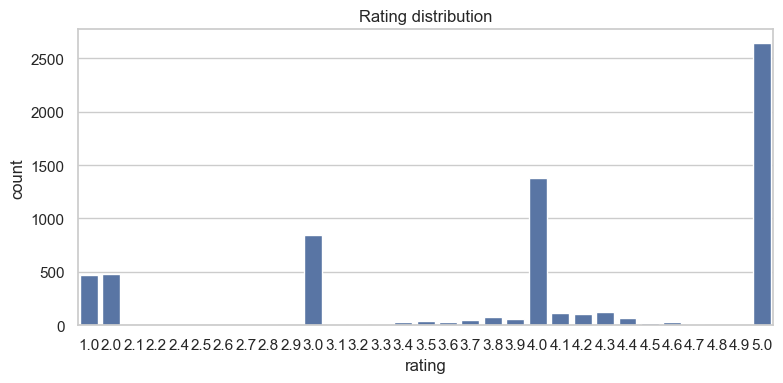

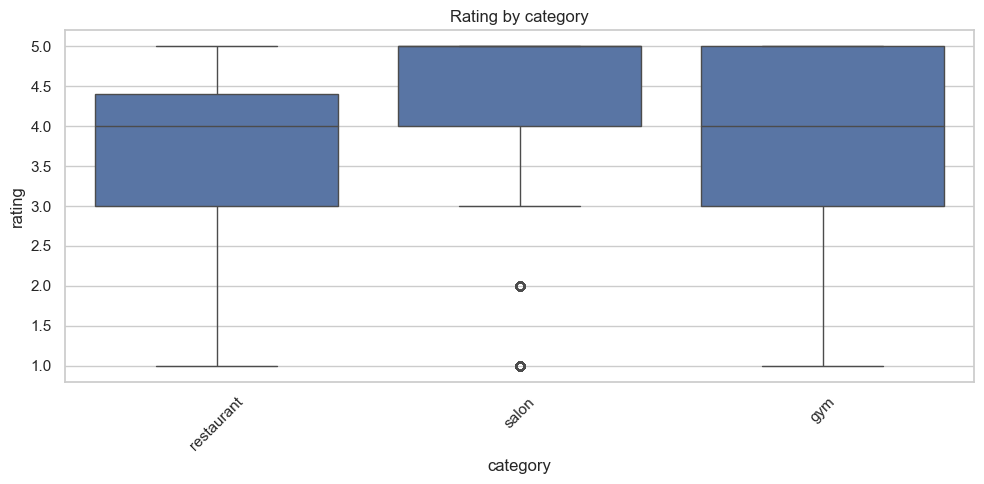

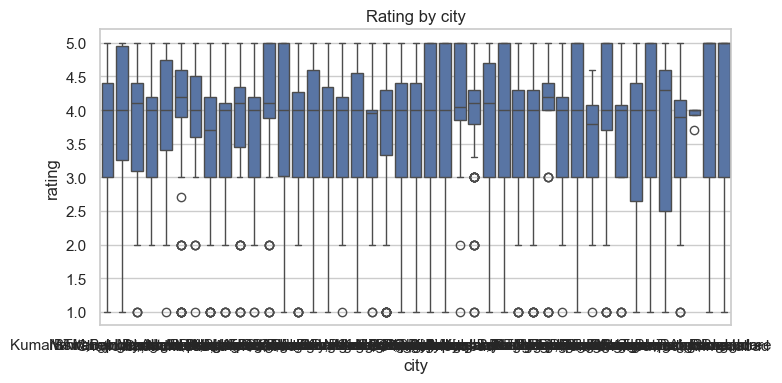

In [8]:
# ----- 6) Rating distribution & boxplots -----
import matplotlib.ticker as mtick

if 'rating' in df.columns and df['rating'].notna().any():
    plt.figure(figsize=(8,4))
    order = sorted(df['rating'].dropna().unique())
    sns.countplot(x='rating', data=df, order=order)
    plt.title('Rating distribution')
    plt.tight_layout()
    plt.show()

if 'category' in df.columns and 'rating' in df.columns:
    plt.figure(figsize=(10,5))
    sns.boxplot(x='category', y='rating', data=df)
    plt.title('Rating by category')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

if 'city' in df.columns and 'rating' in df.columns:
    plt.figure(figsize=(8,4))
    sns.boxplot(x='city', y='rating', data=df)
    plt.title('Rating by city')
    plt.tight_layout()
    plt.show()


In [9]:
# ----- 7) Top & bottom businesses by avg rating (with minimum reviews) -----
if 'business_name' in df.columns and 'rating' in df.columns:
    agg = df.groupby('business_name').agg({'rating':['mean','count']})
    agg.columns = ['rating_mean','rating_count']
    agg = agg.reset_index()
    min_rev = 5
    top = agg[agg['rating_count'] >= min_rev].sort_values('rating_mean', ascending=False).head(10)
    bottom = agg[agg['rating_count'] >= min_rev].sort_values('rating_mean').head(10)
    print('Top businesses (min 5 reviews):')
    display(top)
    print('Bottom businesses (min 5 reviews):')
    display(bottom)


Top businesses (min 5 reviews):


,business_name,rating_mean,rating_count
3667,Quick2Fit - Premium Gym,4.800000,5
4455,The Diamond Gym,4.800000,5
253,Arl Fitness Center (Gym),4.666667,6
1936,Green Fitness Studio,4.600000,5
4508,The Outfit Gym Indiranagar,4.600000,5
4857,Wellcare Gym,4.600000,5
1325,Fitness Edge,4.500000,6
3733,Reforma Fitness - Mathikere,4.444444,9
2043,Hercules Fitness,4.400000,5
549,Black Rhino Fitness,4.333333,9


Bottom businesses (min 5 reviews):


,business_name,rating_mean,rating_count
561,Body Care Gym & Health Center,2.555556,9
4321,Svh Multi Gym,2.750000,8
884,Cult Yelahanka,2.800000,5
3545,Play On Fitness - Cult.Fit Sarjapur,2.888889,9
3611,Prime Fitness Club,2.900000,10
2357,Itc Fabelle Chocolates,2.980000,5
1332,Fitness Solutions,3.000000,6
2278,Ifitness,3.000000,8
4020,Sinew Fitness,3.000000,5
2638,Lf2 Fitness,3.000000,6


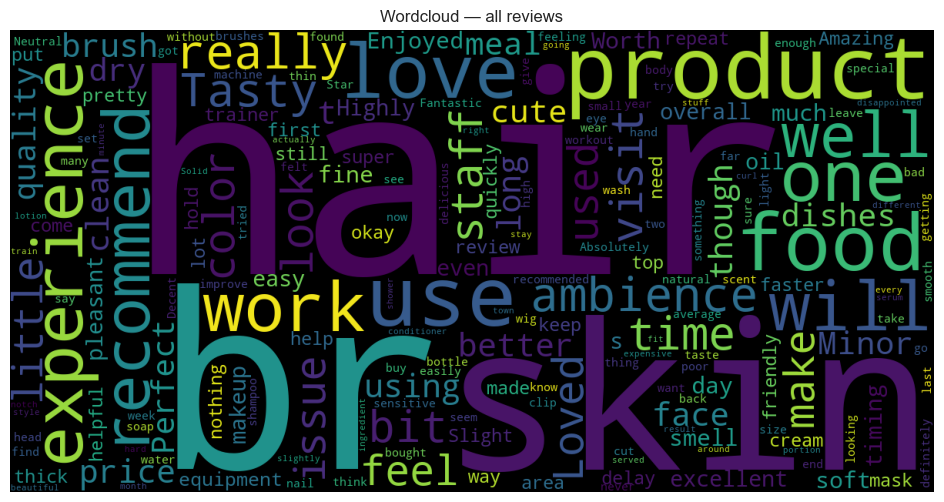

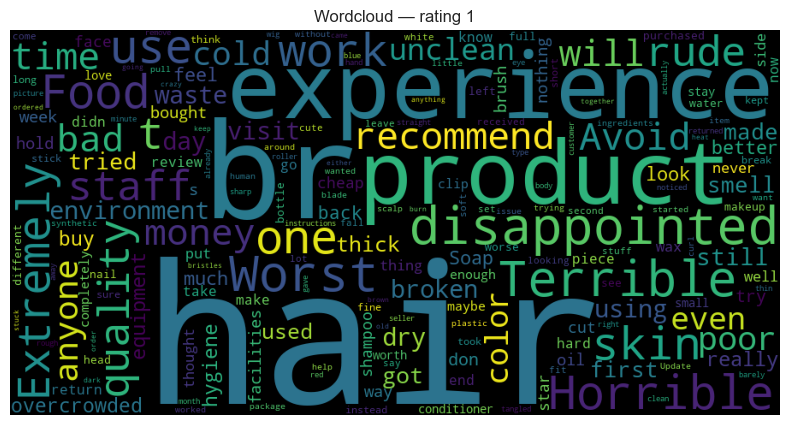

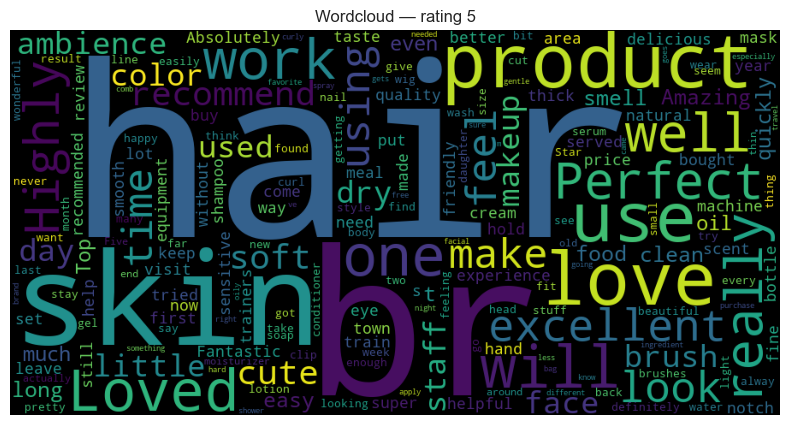

In [10]:
# ----- 8) Wordclouds -----
stopwords = set(STOPWORDS)
stopwords.update(['good','great','nice','best','place','salon','gym','restaurant','service'])

all_text = ' '.join(df['review_text'].astype(str).tolist())
if len(all_text.strip())>0:
    wc = WordCloud(width=1200, height=600, stopwords=stopwords, collocations=False).generate(all_text)
    plt.figure(figsize=(12,6))
    plt.imshow(wc)
    plt.axis('off')
    plt.title('Wordcloud — all reviews')
    plt.show()

if 'rating' in df.columns:
    for r in [1,5]:
        subset = df[df['rating']==r]
        if len(subset) > 0:
            txt = ' '.join(subset['review_text'].astype(str).tolist())
            if len(txt.strip())>0:
                wc2 = WordCloud(width=900, height=450, stopwords=stopwords, collocations=False).generate(txt)
                plt.figure(figsize=(10,5))
                plt.imshow(wc2)
                plt.axis('off')
                plt.title(f'Wordcloud — rating {r}')
                plt.show()


In [11]:
# ----- 9) Top n-grams -----
from sklearn.feature_extraction.text import CountVectorizer

def get_top_ngrams(corpus, ngram_range=(2,2), n=20):
    vec = CountVectorizer(ngram_range=ngram_range, stop_words='english').fit(corpus)
    bag_of_words = vec.transform(corpus)
    sum_words = bag_of_words.sum(axis=0)
    words_freq = [(word, sum_words[0, idx]) for word, idx in vec.vocabulary_.items()]
    words_freq = sorted(words_freq, key=lambda x: x[1], reverse=True)
    return words_freq[:n]

corpus = df['review_text'].astype(str).tolist()
print('Top bigrams:')
print(get_top_ngrams(corpus, ngram_range=(2,2), n=20))
print('\nTop trigrams:')
print(get_top_ngrams(corpus, ngram_range=(3,3), n=20))


Top bigrams:
[('br br', np.int64(674)), ('tasty dishes', np.int64(253)), ('dishes pleasant', np.int64(253)), ('pleasant ambience', np.int64(253)), ('ambience minor', np.int64(253)), ('minor delays', np.int64(253)), ('enjoyed meal', np.int64(243)), ('meal service', np.int64(243)), ('service bit', np.int64(243)), ('bit faster', np.int64(243)), ('slight issues', np.int64(238)), ('nice place', np.int64(236)), ('place tasty', np.int64(236)), ('tasty food', np.int64(236)), ('food slight', np.int64(236)), ('issues timing', np.int64(236)), ('best place', np.int64(226)), ('good experience', np.int64(224)), ('overall worth', np.int64(224)), ('experience overall', np.int64(222))]

Top trigrams:
[('tasty dishes pleasant', np.int64(253)), ('dishes pleasant ambience', np.int64(253)), ('pleasant ambience minor', np.int64(253)), ('ambience minor delays', np.int64(253)), ('enjoyed meal service', np.int64(243)), ('meal service bit', np.int64(243)), ('service bit faster', np.int64(243)), ('nice place tas

In [12]:
# ----- 10) Quick sentiment check with VADER -----
analyzer = SentimentIntensityAnalyzer()

def vader_label(text):
    s = analyzer.polarity_scores(str(text))['compound']
    if s >= 0.05:
        return 'positive'
    elif s <= -0.05:
        return 'negative'
    else:
        return 'neutral'

sample_frac = 0.15 if len(df) > 5000 else 1.0
sample = df.sample(frac=sample_frac, random_state=42).copy()

sample['vader_score'] = sample['review_text'].apply(lambda x: analyzer.polarity_scores(str(x))['compound'])
sample['vader_label'] = sample['review_text'].apply(vader_label)

print('VADER label counts (sample):')
display(sample['vader_label'].value_counts())

if 'rating' in sample.columns:
    def rating_to_sent(r):
        if pd.isna(r): return np.nan
        if r >= 4: return 'positive'
        if r == 3: return 'neutral'
        return 'negative'
    sample['rating_sent'] = sample['rating'].apply(lambda x: rating_to_sent(x) if pd.notnull(x) else np.nan)
    cm = pd.crosstab(sample['rating_sent'], sample['vader_label'], normalize='index')
    print('\nCross-tab: rating_sent vs vader_label (proportions)')
    display(cm)


VADER label counts (sample):


vader_label
positive    823
negative    127
neutral      44
Name: count, dtype: int64


Cross-tab: rating_sent vs vader_label (proportions)


vader_label,negative,neutral,positive
rating_sent,,,
negative,0.515625,0.109375,0.375000
neutral,0.166667,0.159091,0.674242
positive,0.008955,0.002985,0.988060


In [14]:
# ----- 11) Save cleaned sample & optionally full cleaned dataframe -----
OUT_DIR = '../Local Business Review Project NT/data/processed'
os.makedirs(OUT_DIR, exist_ok=True)

clean_master_path = os.path.join(OUT_DIR, 'master_sheet_cleaned.csv')
df.to_csv(clean_master_path, index=False)
print('Saved cleaned master to', clean_master_path)


Saved cleaned master to ../Local Business Review Project NT/data/processed\master_sheet_cleaned.csv
